# Intelligent system for monitoring indoor air quality and fight against COVID-19.<br>
**CO2 forecasting model**.<br>
Notebook developed in Python with the aim to make forecasting time-series in order to predict how CO2 measure is going to fluctuate in a near future.<br>
This forecsting allows a proactive action to alert the users near the device and encourage them to ventilate the indoor area where the device is located.<br>
Author: Felix Angel Martinez Muela

<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png"><br>
**Attribution-NonCommercial-ShareAlike**<br>
**CC BY-NC-SA**

This license lets others remix, adapt, and build upon your work non-commercially, as long as they credit you and license their new creations under the identical terms.<br>
[View License Deed](https://creativecommons.org/licenses/by-nc-sa/4.0) | [View Legal Code](https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode)

Installation of necessary libraries.

In [ ]:
%%capture
!pip install pandas
!pip install matplotlib
!pip install azure-cosmos
!pip install prophet
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [ ]:
import os
import time
import datetime
import json
import itertools
import numpy as np
from azure.cosmos import CosmosClient
import pandas as pd
import plotly.express as px
from fbprophet import Prophet
from prophet.serialize import model_to_json
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

Starting measuring execution time.

In [ ]:
start_time = time.time()

Environment variables.

In [ ]:
os.environ['ACCOUNT_URI'] = "https://airq-cosmos.documents.azure.com:443/"
os.environ['ACCOUNT_KEY'] = "s8bh08THd91Yt6nNbZDN99r6fHH212UCr8l4cuP7v7ySUj3Nps5DDUgIgmIix4QnP481e99UK6NbaQ99AfO9dg=="

CosmosDB client.

In [ ]:
url = os.environ['ACCOUNT_URI']
key = os.environ['ACCOUNT_KEY']

client = CosmosClient(url, credential=key)
database_name = 'airq-db'
database = client.get_database_client(database_name)
container_name = 'telemetry'
container = database.get_container_client(container_name)

NoSQL Data base (CosmosDB) properties.

In [ ]:
properties = database.read()
print(json.dumps(properties))

{"id": "airq-db", "_rid": "vohrAA==", "_self": "dbs/vohrAA==/", "_etag": "\"0000689f-0000-0d00-0000-60b5ee1b0000\"", "_colls": "colls/", "_users": "users/", "_ts": 1622535707}


Unix Timestamp a week before.

In [ ]:
last_x_days=7

In [ ]:
yesterday = datetime.date.today() - datetime.timedelta(last_x_days)
unix_time= yesterday.strftime("%s") #Second as a decimal number [00,61] (or Unix Timestamp)
print(unix_time)

1623801600


Query only  data of the following device.

In [ ]:
deviceid='"24:A1:60:58:09:94"'

Database query.

In [ ]:
query= 'SELECT * FROM c WHERE (c.deviceid = {deviceid}) AND (c.time>{unix_time}) ORDER BY c._ts ASC'.format(deviceid=deviceid, unix_time=unix_time)

Query to the database and document concatenation to a list.

In [ ]:
%%capture
dflist = []
for item in container.query_items(
        query=query,
        enable_cross_partition_query=True):
    print(json.dumps(item, indent=True))
    dflist.append(dict(item))

Explanation of the data received by the CosmosDB database.<br>
Data: <br>
0.   **deviceid**: MAC direction of the device's wifi.
1.   **time**: time at which the measured values were collected with UTC time. Value generated per IoT device.
2.   **temperature**: temperature in Celsius degrees. Value generated by BME280 sensor.
3.   **humidity**: relative humidity percentage %. Value generated by BME280 sensor.
4.   **pressure**: atmospheric pressure in hPa. Value generated by BME280 sensor.
5.   **altitude**: altitude at which the device is located as a function of its atmospheric pressure. Indicative value and that takes as reference the atmospheric pressure at sea level: 1013.25 hPa. Value generated by BME280 sensor.
6.   **co2**: CO2 particles measured in ppm. Value generated by MHZ19 sensor.
7.   **rawco2**: value captured by the sensor regardless of calibration. Value generated by MHZ19 sensor.
8.   **pm25**: 2.5 micron airborne particles measured in ppm. Value generated by SDS011 sensor.
9.   **pm10** 10 micron airborne particles measured in ppm. Value generated by SDS011 sensor.
10.   **tvoc**: Volatile Organic Compound particles in suspension in the air, measured in ppb. Value generated by sensor.
11.   **eco2**: CO2 particles measured in ppm. Value generated by SGP30 sensor.
12.   **rawh2**: dihydrogen particles in the air. Value needed to measure eCO2 and TVOC. Value generated by SGP30 sensor.
13.   **rawethanol**: ethanol particles in the air. Value required to measure eCO2 and TVOC. Value generated by SGP30 sensor.
14.   **lux**: value indicating the brightness found in the environment, measured in lx, equivalent to 1 lm/m² Value generated by VEML7700 sensor.
15.   **whitelux**: value indicating the brightness of the white color found in the environment, measured in lx, equivalent to 1 lm/m². Value generated by VEML7700 sensor.
16.   **rawals**: raw value to obtain lux and whitelux. Value generated by VEML7700 sensor.
17.   **id**: indicates the document identifier. Value generated by the database.
18.   **_rid**: indicates the document identifier. Value generated by the database.
19.   **_self**: indicates the document URI. Value generated by the database.
20.   **_etag**: value necessary to manage the simultaneity of the documents. Value generated by the database.
21.   **_attachments**: indicates attachments associated with the document. Value generated by the database.
22.   **_ts**: indicates when the document was last modified. Value generated by the database.

Creation of the dataframe from the query.

In [ ]:
df = pd.DataFrame(dflist)

We list the number of devices that have sent data.

In [ ]:
devices = df.deviceid.unique()
print(devices)

['24:A1:60:58:09:94']


Select from the data frame only the rows that belong to the device you are interested in.

In [ ]:
df = df.loc[df['deviceid'] == '24:A1:60:58:09:94']

We eliminate from the DF the data that do not add value <br>
The values that for the development of the model do not contribute value are the following: deviceid, altitude, rawco2, rawh2, rawethanol, rawals, id, _rid, _self, _etag, attachements, _ts.

In [ ]:
df = df.drop(['deviceid','altitude','rawco2','rawh2','rawethanol','rawals','id','_rid','_self','_etag','_attachments','_ts'], 1)

In [ ]:
df = df.rename(columns={'time': 'Date'}) # Adjustment of column names
df['Date']= pd.to_datetime(df['Date'], unit='s') # Conversion to date type
df = df.sort_values('Date') # Sort by date
df['Date'] = df['Date'].dt.floor('min') # Approaching seconds to minutes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9259 entries, 0 to 9258
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         9259 non-null   datetime64[ns]
 1   temperature  9259 non-null   float64       
 2   humidity     9259 non-null   float64       
 3   pressure     9259 non-null   float64       
 4   co2          9259 non-null   int64         
 5   pm25         9259 non-null   float64       
 6   pm10         9259 non-null   float64       
 7   tvoc         9259 non-null   int64         
 8   eco2         9259 non-null   int64         
 9   lux          9259 non-null   float64       
 10  whitelux     9259 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(3)
memory usage: 868.0 KB


Graphical representation of the values present in the CosmosDB database.

In [ ]:
fig = px.line(df, x=df.Date, y=df.co2, template = 'plotly_dark')
fig.show()



---


**Prophet**<br>
https://facebook.github.io/prophet/docs/quick_start.html

In [ ]:
df = pd.DataFrame(df, columns=['Date', 'co2'])

Adjustment of the column names, necessary for the library to identify which values are temporary indicators and which are the values to be predicted.

In [ ]:
df.columns = ['ds', 'y']

Prophet with non-daily data, in this case minutes:<br>https://facebook.github.io/prophet/docs/non-daily_data.html<br>
The value of changepoint_prior_scale indicates how flexible the changes in the model will be:

*   A "high" value will cause the model to fit poorly (underfitting).
*   A "low" value will create overfitting and will not generalize the model well.

Since this is a short-term forecast, we want it to be flexible in order to adapt quickly to new changes in the environment, because if the model is not very flexible, the forecast will take a long time to adapt to a last-minute change.

In [ ]:
model = Prophet(changepoint_prior_scale=0.5)

The model has the ability to include national holidays within it to better adapt to seasonality. In case you want to implement the air quality meter in an educational center or a company, it would be of vital importance to add these lines.

In [ ]:
is_public=0
if is_public==1:
  model.add_country_holidays(country_name='ES')

Model training.

In [ ]:
model = model.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Holidays in case it is a public place and therefore affected by public holidays.

In [ ]:
if is_public==1:  
  model.train_holiday_names

Model storage.

In [ ]:
with open('serialized_model.json', 'w') as fout:
    json.dump(model_to_json(model), fout)  # Save model

Prediction model for the **next hour**.<br>
Saturation at maximum and minimum sensor values:


*   Maximum saturation: 5000ppm.
*   Minimum saturation: 400ppm (outside air).

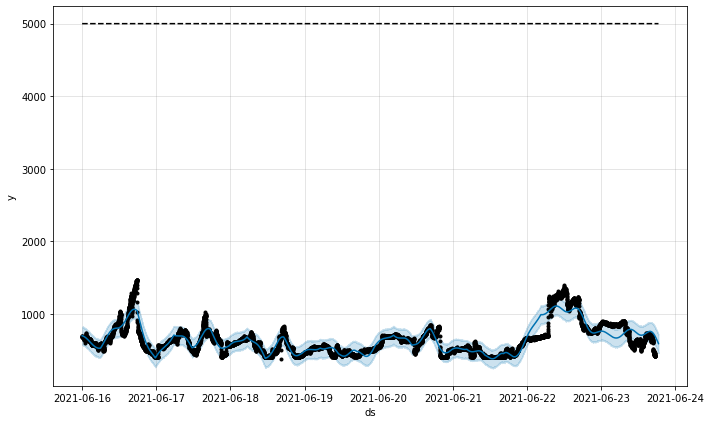

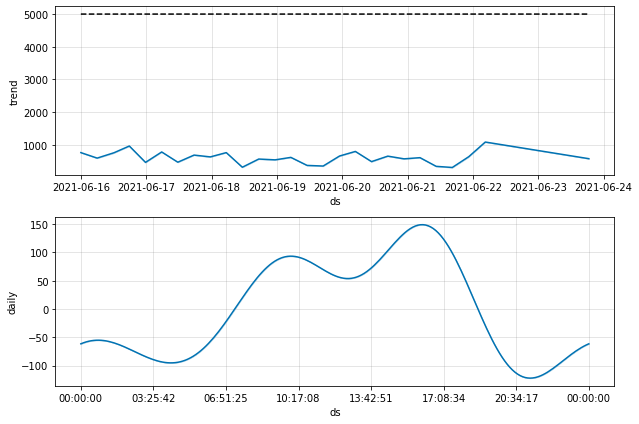

In [ ]:
next_hours = model.make_future_dataframe(periods=60, freq='min')
next_hours['cap'] = 5000
next_hours['floor'] = 400
fcst_hour = model.predict(next_hours)
figh_1 = model.plot(fcst_hour)
figh_2 = model.plot_components(fcst_hour)

Prediction model for the **following day**.<br>
Saturation at sensor maximum and minimum values:


*   Maximum saturation: 5000ppm.
*   Minimum saturation: 400ppm (outside air).



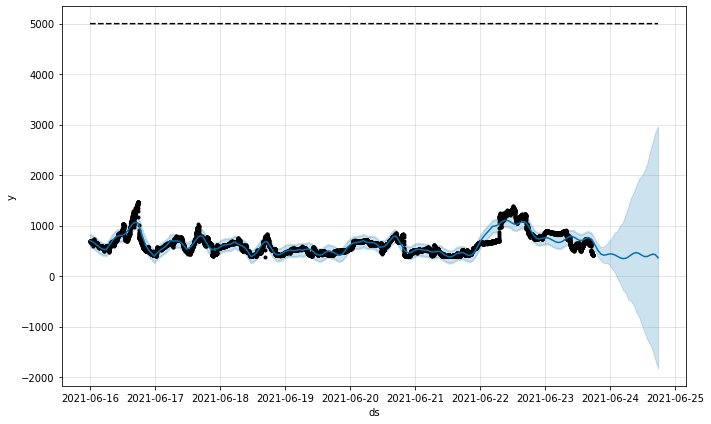

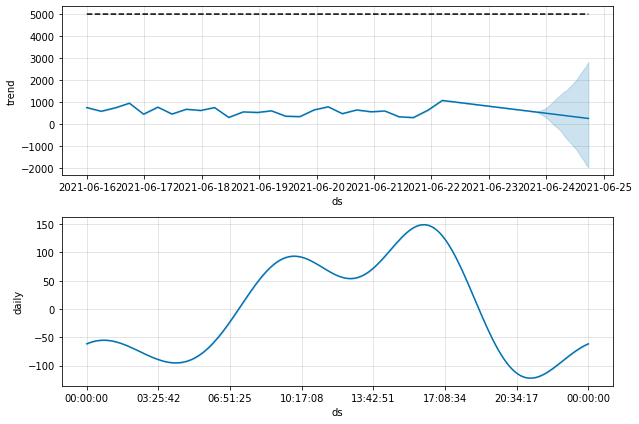

In [ ]:
next_days = model.make_future_dataframe(periods=24, freq='H')
next_days['cap'] = 5000
next_days['floor'] = 400
fcst_days = model.predict(next_days)
figm_1 = model.plot(fcst_days)
figm_2 = model.plot_components(fcst_days)

Values meaning:


*   **ds**: time when the value was achieved or it's going to be achieved.
*   **yhat**: CO2 data predicted by the model.



In [ ]:
fcst_days[["ds","yhat"]].tail()

,ds,yhat
9276,2021-06-24 13:35:00,387.151093
9277,2021-06-24 14:35:00,412.174958
9278,2021-06-24 15:35:00,434.676277
9279,2021-06-24 16:35:00,422.634193
9280,2021-06-24 17:35:00,361.861076


Next hour CO2 forecasting.

In [ ]:
fcst_hour.tail(60)

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
9257,2021-06-23 17:36:00,586.493566,5000,551.822498,806.141032,586.493566,586.493566,95.424462,95.424462,95.424462,95.424462,95.424462,95.424462,0.0,0.0,0.0,681.918028
9258,2021-06-23 17:37:00,586.270346,5000,555.243912,788.824882,586.270346,586.270346,94.258643,94.258643,94.258643,94.258643,94.258643,94.258643,0.0,0.0,0.0,680.528989
9259,2021-06-23 17:38:00,586.047127,5000,549.079009,807.643829,586.047127,586.047127,93.083192,93.083192,93.083192,93.083192,93.083192,93.083192,0.0,0.0,0.0,679.130319
9260,2021-06-23 17:39:00,585.823907,5000,549.260271,801.954928,585.823907,585.823907,91.898251,91.898251,91.898251,91.898251,91.898251,91.898251,0.0,0.0,0.0,677.722158
9261,2021-06-23 17:40:00,585.600687,5000,552.019262,793.576301,585.600687,585.600687,90.703961,90.703961,90.703961,90.703961,90.703961,90.703961,0.0,0.0,0.0,676.304649
9262,2021-06-23 17:41:00,585.377468,5000,548.299068,794.839121,585.377468,585.377468,89.500468,89.500468,89.500468,89.500468,89.500468,89.500468,0.0,0.0,0.0,674.877936
9263,2021-06-23 17:42:00,585.154248,5000,542.884066,793.711095,585.154248,585.154248,88.287916,88.287916,88.287916,88.287916,88.287916,88.287916,0.0,0.0,0.0,673.442164
9264,2021-06-23 17:43:00,584.931029,5000,558.999734,795.277395,584.931029,584.931029,87.066453,87.066453,87.066453,87.066453,87.066453,87.066453,0.0,0.0,0.0,671.997482
9265,2021-06-23 17:44:00,584.707809,5000,545.382700,788.239228,584.707809,584.707809,85.836228,85.836228,85.836228,85.836228,85.836228,85.836228,0.0,0.0,0.0,670.544037
9266,2021-06-23 17:45:00,584.484589,5000,551.870859,786.572690,584.484589,584.484589,84.597391,84.597391,84.597391,84.597391,84.597391,84.597391,0.0,0.0,0.0,669.081980


Next day CO2 forecasting.

In [ ]:
fcst_days.tail(24)

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
9257,2021-06-23 18:35:00,573.323609,5000,468.019071,707.450925,573.323609,573.323609,15.326334,15.326334,15.326334,15.326334,15.326334,15.326334,0.0,0.0,0.0,588.649944
9258,2021-06-23 19:35:00,559.930434,5000,367.885612,622.782763,555.623301,570.629258,-65.351688,-65.351688,-65.351688,-65.351688,-65.351688,-65.351688,0.0,0.0,0.0,494.578746
9259,2021-06-23 20:35:00,546.537258,5000,293.981949,573.348074,516.944666,588.480823,-113.888506,-113.888506,-113.888506,-113.888506,-113.888506,-113.888506,0.0,0.0,0.0,432.648752
9260,2021-06-23 21:35:00,533.144082,5000,256.887501,584.865558,466.630322,631.270018,-120.100397,-120.100397,-120.100397,-120.100397,-120.100397,-120.100397,0.0,0.0,0.0,413.043685
9261,2021-06-23 22:35:00,519.750906,5000,257.207131,628.323027,405.628832,667.341374,-97.355089,-97.355089,-97.355089,-97.355089,-97.355089,-97.355089,0.0,0.0,0.0,422.395818
9262,2021-06-23 23:35:00,506.357730,5000,232.681543,702.551388,331.807959,719.559177,-69.698061,-69.698061,-69.698061,-69.698061,-69.698061,-69.698061,0.0,0.0,0.0,436.659670
9263,2021-06-24 00:35:00,492.964554,5000,151.250417,756.280694,236.803164,799.134232,-55.691320,-55.691320,-55.691320,-55.691320,-55.691320,-55.691320,0.0,0.0,0.0,437.273235
9264,2021-06-24 01:35:00,479.571379,5000,80.608859,855.608419,142.959590,904.777838,-60.153275,-60.153275,-60.153275,-60.153275,-60.153275,-60.153275,0.0,0.0,0.0,419.418104
9265,2021-06-24 02:35:00,466.178203,5000,-38.356444,890.180225,44.786078,1000.258029,-76.106080,-76.106080,-76.106080,-76.106080,-76.106080,-76.106080,0.0,0.0,0.0,390.072123
9266,2021-06-24 03:35:00,452.785027,5000,-140.802091,1004.889392,-72.691157,1110.758105,-91.417774,-91.417774,-91.417774,-91.417774,-91.417774,-91.417774,0.0,0.0,0.0,361.367253




---

**Cross validation**


Method to test how good our model is at predicting.
To calculate this we will take a sample of our actual data, tell our model to predict and see the difference between the actual data and the predicted data.<br>
Parallelism methods applicable to cross validation:
*   parallel=None (Default, no parallelization)
*   parallel="processes"
*   parallel="threads"
*   parallel="dask"
<br>

*   Initial: indicates the unit of time of trained data prior to the first cut that we will use.
*   Period: indicates how often a prediction will be made.
*   Horizon: period during which the prediction performance will be evaluated.

In [ ]:
df_cv = cross_validation(model, initial='3 days', period='12 hours', horizon='1 days', parallel="processes")

INFO:prophet:Making 8 forecasts with cutoffs between 2021-06-19 05:35:00 and 2021-06-22 17:35:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fce5e588790>




*   **ds**: time when the data is measured.
*   **yhat**: predicted value.
*   **yhat_lower**: lower confidence range of the prediction
*   **yhat_upper**: upper confidence range of the prediction.
*   **y**: real value measured by the sensor.
*   **cutoff**: limit of the prediction scope.

In [ ]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-06-19 05:36:00,524.147674,444.664596,597.872467,536,2021-06-19 05:35:00
1,2021-06-19 05:37:00,523.963501,444.319365,598.318983,538,2021-06-19 05:35:00
2,2021-06-19 05:38:00,523.783110,446.480327,600.554856,531,2021-06-19 05:35:00
3,2021-06-19 05:40:00,523.434086,451.939463,596.694938,527,2021-06-19 05:35:00
4,2021-06-19 05:41:00,523.265654,450.247754,596.363857,525,2021-06-19 05:35:00
...,...,...,...,...,...,...
9560,2021-06-23 17:31:00,1940.796104,-866.819926,5001.510272,419,2021-06-22 17:35:00
9561,2021-06-23 17:32:00,1940.329147,-864.350449,4908.190910,424,2021-06-22 17:35:00
9562,2021-06-23 17:33:00,1939.853092,-863.043015,5002.084255,422,2021-06-22 17:35:00
9563,2021-06-23 17:34:00,1939.368040,-895.212014,5024.837976,415,2021-06-22 17:35:00


Key Performance Indicators for time-series model.<br>

*   **MSE**: Mean Squared Error.
*   **RMSE**: Root Mean Square Error.
*   **MAE**: Mean Absolute Error.
*   **MAPE**: Mean Absolute Percentage Error.
*   **MDAPE**: Median Absolute Percentage Error.
*   **SMAPE**: Symmetric Mean Absolute Percentage Error.
*   **coverage**: confidence interval.

In [ ]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 02:24:00,41698.428621,204.201931,150.320933,0.225769,0.197695,0.240172,0.447001
1,0 days 02:25:00,42053.032738,205.068361,151.197943,0.227063,0.199199,0.241766,0.443365
2,0 days 02:26:00,42186.254722,205.392928,151.725433,0.228243,0.202170,0.243043,0.440227
3,0 days 02:27:00,42533.776855,206.237186,152.699341,0.229696,0.204768,0.244643,0.436541
4,0 days 02:28:00,42901.178073,207.125996,153.710780,0.231221,0.206657,0.246370,0.432357


Representation of the validation metric called **MAPE** (Mean Absolute Percentage Error).<br>
$M=\frac{1}{n}\sum_{i=1}^{n}\left | \frac{A_{t} - F_{t}}{A_t}\right |$<br>


*   **n** is the number of fitted points.
*   **At** is the actual value.
*   **Ft** is the forecast value.
*   **Σ** is summation notation (the absolute value is summed for every forecasted point in time).



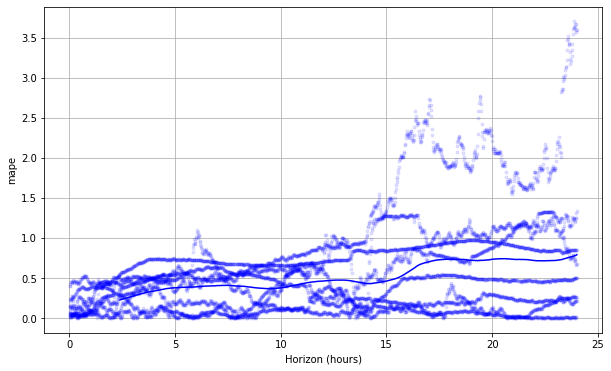

In [ ]:
fig = plot_cross_validation_metric(df_cv, metric='mape')



---


**Hyperparameter tuning** in order to find the best external parameters of the model to find those that reduce the error of the training and validation data. <br>
$rmse = \sqrt{(\frac{1}{n})\sum_{i=1}^{n}(y_{i} - x_{i})^{2}}
$


In [ ]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
contador_iteraccion = 0
# Use cross validation to evaluate all parameters
for params in all_params:
    contador_iteraccion=contador_iteraccion+1
    print(f'Iteraccion: {contador_iteraccion} de un total de: {len(all_params)}')
    print(params)
    model = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(model, initial='3 days', period='12 hours', horizon='1 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Iteraccion: 1 de un total de: 16
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}


INFO:prophet:Making 8 forecasts with cutoffs between 2021-06-19 05:35:00 and 2021-06-22 17:35:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fce41e67510>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Iteraccion: 2 de un total de: 16
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1}


INFO:prophet:Making 8 forecasts with cutoffs between 2021-06-19 05:35:00 and 2021-06-22 17:35:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fce4260ae90>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Iteraccion: 3 de un total de: 16
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0}


INFO:prophet:Making 8 forecasts with cutoffs between 2021-06-19 05:35:00 and 2021-06-22 17:35:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fce4260a150>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Iteraccion: 4 de un total de: 16
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0}


INFO:prophet:Making 8 forecasts with cutoffs between 2021-06-19 05:35:00 and 2021-06-22 17:35:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fce42556550>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Iteraccion: 5 de un total de: 16
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


INFO:prophet:Making 8 forecasts with cutoffs between 2021-06-19 05:35:00 and 2021-06-22 17:35:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fce4c059d50>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Iteraccion: 6 de un total de: 16
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


INFO:prophet:Making 8 forecasts with cutoffs between 2021-06-19 05:35:00 and 2021-06-22 17:35:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fce42493b90>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Iteraccion: 7 de un total de: 16
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


INFO:prophet:Making 8 forecasts with cutoffs between 2021-06-19 05:35:00 and 2021-06-22 17:35:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fce41e4d0d0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Iteraccion: 8 de un total de: 16
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0}


INFO:prophet:Making 8 forecasts with cutoffs between 2021-06-19 05:35:00 and 2021-06-22 17:35:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fce425c4150>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Iteraccion: 9 de un total de: 16
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


INFO:prophet:Making 8 forecasts with cutoffs between 2021-06-19 05:35:00 and 2021-06-22 17:35:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fce4258cad0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Iteraccion: 10 de un total de: 16
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


INFO:prophet:Making 8 forecasts with cutoffs between 2021-06-19 05:35:00 and 2021-06-22 17:35:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fce4244d310>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Iteraccion: 11 de un total de: 16
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}


INFO:prophet:Making 8 forecasts with cutoffs between 2021-06-19 05:35:00 and 2021-06-22 17:35:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fce42313f10>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Iteraccion: 12 de un total de: 16
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}


INFO:prophet:Making 8 forecasts with cutoffs between 2021-06-19 05:35:00 and 2021-06-22 17:35:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fce4245b350>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Iteraccion: 13 de un total de: 16
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}


INFO:prophet:Making 8 forecasts with cutoffs between 2021-06-19 05:35:00 and 2021-06-22 17:35:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fce42520190>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Iteraccion: 14 de un total de: 16
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1}


INFO:prophet:Making 8 forecasts with cutoffs between 2021-06-19 05:35:00 and 2021-06-22 17:35:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fce41e3be10>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Iteraccion: 15 de un total de: 16
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0}


INFO:prophet:Making 8 forecasts with cutoffs between 2021-06-19 05:35:00 and 2021-06-22 17:35:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fce65f6a210>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Iteraccion: 16 de un total de: 16
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0}


INFO:prophet:Making 8 forecasts with cutoffs between 2021-06-19 05:35:00 and 2021-06-22 17:35:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fce424becd0>


    changepoint_prior_scale  seasonality_prior_scale        rmse
0                     0.001                     0.01  305.185132
1                     0.001                     0.10  306.047135
2                     0.001                     1.00  305.404176
3                     0.001                    10.00  304.520168
4                     0.010                     0.01  458.391217
5                     0.010                     0.10  460.918321
6                     0.010                     1.00  458.944249
7                     0.010                    10.00  460.749875
8                     0.100                     0.01  507.485532
9                     0.100                     0.10  528.521775
10                    0.100                     1.00  524.559396
11                    0.100                    10.00  527.869290
12                    0.500                     0.01  487.517781
13                    0.500                     0.10  488.090758
14                    0.5

Cross validation result.

In [ ]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0}


Execution time finished.

In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 1577.2607231140137 seconds ---
